In [55]:
import os
os.chdir(r"c:\Users\britt\Desktop\YH\Applicerad AI\job_discrimination_sandbox")
import re
import warnings

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import pickle
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from nltk import pos_tag
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from unidecode import unidecode

In [7]:
with open("data/cleaned_data/cross_val_split.pkl", "rb") as read_file:
    folds = pickle.load(read_file)

In [8]:
def objective(trial):
    C = trial.suggest_float("C", 1e-7, 10.0, log=True)
    c_weight = trial.suggest_categorical("c_weight", ["balanced", None])

    clf = LogisticRegression(C=C, class_weight=c_weight)
    scores = []
    for fold in folds[:-1]:
        clf.fit(fold["Train X Tfidf"], fold["Train y classes"])
        scores.append(clf.score(fold["Test X Tfidf"], fold["Test y classes"]))

    return np.mean(scores)

In [10]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=500)

[I 2023-01-24 09:59:26,938] A new study created in memory with name: no-name-6addbcc6-826e-4ceb-946b-dec0588a961e
[I 2023-01-24 09:59:27,485] Trial 0 finished with value: 0.6310820624546114 and parameters: {'C': 0.20523591812961905, 'c_weight': None}. Best is trial 0 with value: 0.6310820624546114.
[I 2023-01-24 09:59:28,076] Trial 1 finished with value: 0.593681917211329 and parameters: {'C': 0.00032003679905692344, 'c_weight': None}. Best is trial 0 with value: 0.6310820624546114.
[I 2023-01-24 09:59:28,391] Trial 2 finished with value: 0.8133623819898329 and parameters: {'C': 0.011587636595417509, 'c_weight': 'balanced'}. Best is trial 2 with value: 0.8133623819898329.
[I 2023-01-24 09:59:29,278] Trial 3 finished with value: 0.7752360203340596 and parameters: {'C': 0.540383604541825, 'c_weight': None}. Best is trial 2 with value: 0.8133623819898329.
[I 2023-01-24 09:59:30,509] Trial 4 finished with value: 0.8257080610021785 and parameters: {'C': 2.101960304235772, 'c_weight': None}.

In [11]:
study.best_params

{'C': 2.6716377026717955, 'c_weight': 'balanced'}

In [37]:
clf = LogisticRegression(C=2.672, class_weight="balanced")
scores = []
for fold in folds[:-1]:
    clf.fit(fold["Train X Tfidf"], fold["Train y classes"])
    scores.append(clf.score(fold["Test X Tfidf"], fold["Test y classes"]))

np.mean(scores)

0.8449527959331882

In [38]:
test_set = folds[-1]
#clf = LogisticRegression(C=2.672, class_weight="balanced")
clf.fit(test_set["Train X Tfidf"], test_set["Train y classes"])
clf.score(test_set["Test X Tfidf"], test_set["Test y classes"])

0.8823529411764706

In [39]:
pred = clf.predict(test_set["Test X Tfidf"])

acc = accuracy_score(pred, test_set["Test y classes"])
recall = recall_score(pred, test_set["Test y classes"], average="weighted")
precision = precision_score(pred, test_set["Test y classes"], average="weighted")
f1 = f1_score(pred, test_set["Test y classes"], average="weighted")

c:\Users\britt\Desktop\YH\Applicerad AI\job_discrimination_sandbox\venv\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [43]:
print("Classification with logistic regression and Tf-Idf model:")
print(f"Score: {round(acc, 3)}")
print(f"F1: {round(f1, 3)}")
print(f"Recall: {round(recall, 3)}")
print(f"Precision: {round(precision, 3)}")

Classification with logistic regression and Tf-Idf model:
Score: 0.882
F1: 0.91
Recall: 0.882
Precision: 0.941


In [41]:
cm = confusion_matrix(y_true=test_set["Test y classes"], y_pred=pred, labels=clf.classes_)

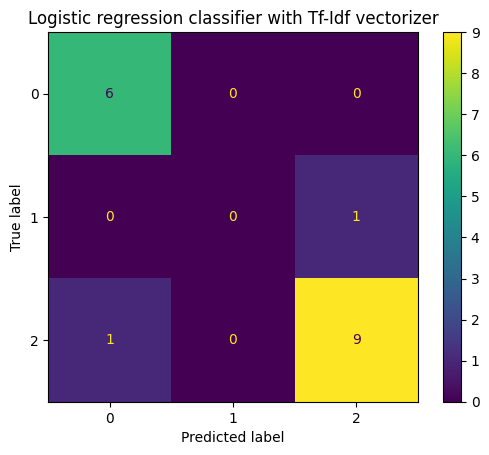

In [44]:
plot = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
plot.plot()
plt.title("Logistic regression classifier with Tf-Idf vectorizer")
plt.show()

In [45]:
weights = clf.coef_
weights

array([[-0.01210623,  0.00521771, -0.01402882, ...,  0.03067807,
         0.05133926,  0.11013381],
       [-0.00758152, -0.01342122, -0.01151428, ..., -0.01115658,
        -0.00610143, -0.06533872],
       [ 0.01968775,  0.00820351,  0.02554311, ..., -0.01952149,
        -0.04523783, -0.0447951 ]])

In [150]:
corpus = list(df["Cleaned text"])
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit_transform(corpus)
vocabulary = tfidf_vectorizer.get_feature_names_out()

In [144]:
vocabulary

array(['ab', 'abatement', 'abbreviation', ..., 'youth', 'zero', 'zone'],
      dtype=object)

In [52]:
def get_n_most_important_words(weights, vocabulary, n):
    indices = np.argpartition(weights, len(weights) - n)[-n:]
    min_elements = weights[indices]
    min_elements_order = np.argsort(min_elements)
    ordered_indices = indices[min_elements_order]
    words = [vocabulary[i] for i in ordered_indices]
    weights = [round(weights[i], 5) for i in ordered_indices]

    return words[::-1], weights[::-1]

In [53]:
print("Top 25 important words for classifying neutral bulletins:")
neutr_words, neutr_weights = get_n_most_important_words(weights[0], vocabulary, 25)
for word, weight in list(zip(neutr_words, neutr_weights)):
    print(f"{word}: {weight}")
print("\nTop 25 important words for classifying female bulletins:")
fem_words, fem_weights = get_n_most_important_words(weights[1], vocabulary, 25)
for word, weight in list(zip(fem_words, fem_weights)):
    print(f"{word}: {weight}")
print("\nTop 25 important words for classifying male bulletins:")
masc_words, masc_weights = get_n_most_important_words(weights[2], vocabulary, 25)
for word, weight in list(zip(masc_words, masc_weights)):
    print(f"{word}: {weight}")

Top 25 important words for classifying neutral bulletins:
art: 1.12374
financial: 1.09999
animal: 1.05706
recreation: 1.03801
environmental: 0.94303
graphic: 0.88575
management: 0.86905
city: 0.85367
degree: 0.78804
committee: 0.7453
qualify: 0.74471
analysis: 0.70995
analyst: 0.70597
administration: 0.61661
professional: 0.60021
data: 0.59499
accountant: 0.58315
public: 0.54835
expert: 0.53397
buyer: 0.51381
landscape: 0.50949
park: 0.50643
business: 0.50454
recreational: 0.49052
supply: 0.48219

Top 25 important words for classifying female bulletins:
volunteer: 2.24791
customer: 1.94961
clerical: 1.89751
representative: 1.31381
compensation: 1.25987
clerk: 1.18344
accounting: 1.16846
executive: 1.00357
pba: 0.94455
claim: 0.85419
account: 0.66274
coordinator: 0.65075
worker: 0.6405
background: 0.6337
relation: 0.62312
may: 0.61231
bookkeeping: 0.60537
payment: 0.5737
secretary: 0.56712
typing: 0.56673
independently: 0.56031
press: 0.55155
preliminary: 0.55111
service: 0.51901
june: 

In [115]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith("J"):
        return wordnet.ADJ
    elif treebank_tag.startswith("V"):
        return wordnet.VERB
    elif treebank_tag.startswith("N"):
        return wordnet.NOUN
    elif treebank_tag.startswith("R"):
        return wordnet.ADV
    else:
        return ""


def penn_to_wn(tag):
    return get_wordnet_pos(tag)


def preprocess_document(doc):
    lemmatizer = WordNetLemmatizer()

    remove_https = re.sub(r"http\S+", "", doc)
    remove_com = re.sub(r"\ [A-Za-a]*\.com", " ", remove_https)
    remove_numbers_punctuations = re.sub(r"[^a-zA-Z]+", " ", remove_com)
    pattern = re.compile(r"\s+")
    remove_extra_whitespaces = re.sub(pattern, " ", remove_numbers_punctuations)
    only_ascii = unidecode(remove_extra_whitespaces)
    doc = only_ascii.lower()

    list_of_tokens = word_tokenize(doc)
    list_of_tokens_pos = pos_tag(list_of_tokens)
    list_of_tokens_wn_pos = [(token[0], penn_to_wn(token[1])) for token in list_of_tokens_pos if token[0] not in stopwords.words("english")]
    list_of_lemmas = [lemmatizer.lemmatize(token[0], token[1]) if token[1] != "" else lemmatizer.lemmatize(token[0]) for token in list_of_tokens_wn_pos]
    cleaned_text = [" ".join(list_of_lemmas)]

    return cleaned_text

In [140]:
file_name = "ASBESTOS WORKER 3435 100518.txt"

with open(f"data/original_data/job_bulletins/{file_name}", "r", encoding="utf-8") as f:
    application = f.read()

cleaned = preprocess_document(application)

In [141]:
with open("data/vectorizers/tfidf.pkl", "rb") as read_file:
    vectorizer = pickle.load(read_file)

In [142]:
vectorized_text = vectorizer.transform(cleaned)
prediction = clf.predict(vectorized_text)
pred_probas = clf.predict_proba(vectorized_text)

In [143]:
label_to_word = {1: "female", 2: "male"}

print(f"The job advertisement {file_name} will most likely (with {round(pred_probas[0][prediction[0]] * 100, 2)}% probability) get", end=" ")
if 0 < prediction[0]:
    print(f"more than 70% {label_to_word[prediction[0]]} applicants.")
else:
    print("around as many female as male applicants")
print(f"The probability for the advertisement getting more than 70% female applicants is {round(pred_probas[0][1] * 100, 2)}%")
print(f"The probability for the advertisement getting around as many female as male applicants is {round(pred_probas[0][0] * 100, 2)}%")

The job advertisement ASBESTOS WORKER 3435 100518.txt will most likely (with 63.25% probability) get more than 70% male applicants.
The probability for the advertisement getting more than 70% female applicants is 14.29%
The probability for the advertisement getting around as many female as male applicants is 22.46%


In [126]:
pred_probas[0][2]

0.6325177124360106

In [147]:
tfidf_vectorizer.fit_transform(cleaned)
cleaned_vocabulary = tfidf_vectorizer.get_feature_names_out()

In [152]:
get_n_most_important_words(weights[2], vocabulary, 3600)

(['electrical',
  'equipment',
  'construction',
  'maintenance',
  'engineering',
  'repair',
  'inspector',
  'engineer',
  'fire',
  'security',
  'mechanical',
  'installation',
  'geologist',
  'operator',
  'cable',
  'lapd',
  'elevator',
  'system',
  'airport',
  'building',
  'safety',
  'distribution',
  'mechanic',
  'officer',
  'telecommunication',
  'vehicle',
  'street',
  'operation',
  'metal',
  'light',
  'certificate',
  'meter',
  'tool',
  'electric',
  'investment',
  'waterworks',
  'journey',
  'warehouse',
  'automotive',
  'motor',
  'online',
  'window',
  'inspection',
  'material',
  'california',
  'electrician',
  'water',
  'draft',
  'inspect',
  'visual',
  'sheet',
  'flat',
  'rat',
  'steam',
  'component',
  'treatment',
  'control',
  'use',
  'plumbing',
  'license',
  'supervisor',
  'truck',
  'traffic',
  'plant',
  'load',
  'carpet',
  'performance',
  'communication',
  'geology',
  'firefighter',
  'read',
  'superintendent',
  'cleaner'

In [159]:
masc_words, masc_weights = get_n_most_important_words(weights[2], vocabulary, len(vocabulary))
masc_words_weights = list(zip(masc_words, masc_weights))
masc_words_weights_dict = dict(zip(masc_words, masc_weights))

In [163]:
masc_words_weights_dict

{'electrical': 1.27613,
 'equipment': 1.11581,
 'construction': 0.87271,
 'maintenance': 0.87271,
 'engineering': 0.87087,
 'repair': 0.83962,
 'inspector': 0.75487,
 'engineer': 0.75374,
 'fire': 0.75188,
 'security': 0.74961,
 'mechanical': 0.63769,
 'installation': 0.59377,
 'geologist': 0.58734,
 'operator': 0.58672,
 'cable': 0.56754,
 'lapd': 0.56753,
 'elevator': 0.55674,
 'system': 0.55081,
 'airport': 0.54,
 'building': 0.53607,
 'safety': 0.52017,
 'distribution': 0.49688,
 'mechanic': 0.47556,
 'officer': 0.45717,
 'telecommunication': 0.45252,
 'vehicle': 0.44958,
 'street': 0.4452,
 'operation': 0.43891,
 'metal': 0.42385,
 'light': 0.416,
 'certificate': 0.40577,
 'meter': 0.39186,
 'tool': 0.39071,
 'electric': 0.3878,
 'investment': 0.38709,
 'waterworks': 0.3672,
 'journey': 0.36587,
 'warehouse': 0.36303,
 'automotive': 0.36038,
 'motor': 0.35745,
 'online': 0.35577,
 'window': 0.35477,
 'inspection': 0.35334,
 'material': 0.35157,
 'california': 0.34289,
 'electricia